# **Artificial Neural Networks and Deep Learning**
# **Homework 2: Image Segmentation**
# **FCNN Model from Scratch**

Students:

*   Julián Jiménez: 10657117
*   Samuel Polo: 10670388

# **Our approach of the Task**:

# **Initial approach**

We started the project with the basic FCNN Model that we had seen in class and created in the laboratory session. 

The model consists of a basic encoder and decoder. The encoder part downsamples the images using convolutions, with relu activation functions and max pooling, this reduces the resolution of the image, but increases the number of channels. The repetition of this process increases the number of filters of the convolution that allows us to create a latent representation of the image.

The decoder consists of upsampling layers that increase the resolution of the image and convolutions that reduce the number of filters getting back to the original dimensions of the image in order to do a prediction.
The final prediction layer is a 1x1 convolution with a sigmoid activation function, that maps on to each pixel the probability that it belongs to one class. For this reason as a loss function we utilized binary cross entropy.

Data augmentation is important for data segmentation and for this reason we perform a series of image transformations in order to improve the accuracy of our model. We apply rotations, shifts, flips and zooms in order for our model to be invariant with respect to these transformations and increase robustness.

We trained the model for 100 epochs to see initial results, reverting to the weights obtained in the epoch with the lowest validation error. We then tried by varying some parameters of the model or increasing the training epochs, but we were not able to improve the results. For this reason we decided to move to using transfer learning as we wanted to use a more powerful model.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
#Code to bring data from MyGoogleDrive to Python Notebook.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import os

In [0]:
# Set the seed for random operations. 
# This allows our process to be reproducible. 

SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()
print(cwd)

/content


In [0]:
!unzip /content/drive/My\ Drive/Datasets/Segmentation_Dataset.zip

Archive:  /content/drive/My Drive/Datasets/Segmentation_Dataset.zip
  inflating: Segmentation_Dataset/test/images/img/1029.tif  
  inflating: Segmentation_Dataset/test/images/img/1030.tif  
  inflating: Segmentation_Dataset/test/images/img/1031.tif  
  inflating: Segmentation_Dataset/test/images/img/1032.tif  
  inflating: Segmentation_Dataset/test/images/img/1033.tif  
  inflating: Segmentation_Dataset/test/images/img/1034.tif  
  inflating: Segmentation_Dataset/test/images/img/1035.tif  
  inflating: Segmentation_Dataset/test/images/img/1144.tif  
  inflating: Segmentation_Dataset/test/images/img/1145.tif  
  inflating: Segmentation_Dataset/test/images/img/1146.tif  
  inflating: Segmentation_Dataset/test/images/img/1147.tif  
  inflating: Segmentation_Dataset/test/images/img/1148.tif  
  inflating: Segmentation_Dataset/test/images/img/1149.tif  
  inflating: Segmentation_Dataset/test/images/img/1150.tif  
  inflating: Segmentation_Dataset/test/images/img/1151.tif  
  inflating: Segm

In [0]:
#Set the directories for all, training and validation images.

dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')
training_dir = os.path.join(dataset_dir,'training')
valid_dir = os.path.join(dataset_dir,'validation')

# **Validation Directory Creation**

This code is used to create the validation directory and fill it up with images from all the classes. We use hold-out set validation where we take out a percentage of the training set to use for validation. In our case we decided to use a 80-20 split of the training set.

In [0]:
#Creates validation directory if it does not exist already.
_ = os.makedirs(valid_dir, exist_ok=True)

In [0]:
#Proportion for Hold-out set validation.
train_valid_split = 0.2

#Fills the validation set 
subfolders = [f.path for f in os.scandir(training_dir) if f.is_dir() ] 
flag = True
for subfold in subfolders:
  head_tail = os.path.split(subfold)
  _ = os.makedirs(os.path.join(valid_dir,head_tail[1],'img'), exist_ok=True)
  list_files = [name for name in os.scandir(os.path.join(subfold,'img')) if os.path.isfile(name)]
  num_files = len(list_files)
  if flag:
     rand = np.random.choice(num_files, int(num_files*train_valid_split) ,replace=False)
     flag = False
  for num in rand:
    file_name = os.path.split(list_files[num])
    os.rename(list_files[num],os.path.join(valid_dir,head_tail[1],'img',file_name[1]))

In [0]:
import json

dataset_split = {}
training_list = []
list_files = [name for name in os.scandir(os.path.join(training_dir,'images','img')) if os.path.isfile(name)]
for f in list_files:
  file_name = os.path.split(f)
  training_list.append(file_name[1])
valid_list = []
list_files = [name for name in os.scandir(os.path.join(valid_dir,'images','img')) if os.path.isfile(name)]
for f in list_files:
  file_name = os.path.split(f)
  valid_list.append(file_name[1])

dataset_split['training'] = training_list
dataset_split['validation'] = valid_list

with open('dataset_split.json', 'w') as fp:
     json.dump(dataset_split, fp)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

#**Training and Validation Generators and Datasets**

In [0]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=10,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rotation_range=10,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             rescale=1./255)
      #Use rescale=1./255 in the mask ImageDataGenerator to obtain binary values {0, 1} as target.
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(rescale=1./255)
valid_mask_data_gen = ImageDataGenerator(rescale=1./255)

In [0]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, 'Segmentation_Dataset')

# Batch size
bs = 32

# img shape
img_h = 256
img_w = 256

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         color_mode = 'grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = os.path.join(dataset_dir, 'validation')
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         color_mode='grayscale',
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


In [0]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))

def prepare_target(x_, y_):
    y_ = tf.cast(y_, tf.int32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

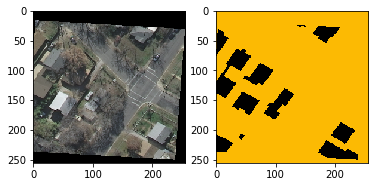

In [0]:
# Testing data generator
# -------------------------
import time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.show()

# Assign a color to each class
colors_dict = {}
colors_dict[0] = [252, 186, 3]  # foreground
colors_dict[1] = [0, 0, 0]  # background

iterator = iter(train_dataset)

for _ in range(100):
    augmented_img, target = next(iterator)
    augmented_img = augmented_img[0]   # First element
    augmented_img = augmented_img * 255  # denormalize
    
    target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
    
    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    
    target_img[np.where(target == 0)] = colors_dict[0]
    target_img[np.where(target == 1)] = colors_dict[1]
    
    ax[0].imshow(np.uint8(augmented_img))
    ax[1].imshow(np.uint8(target_img))
    plt.show()

    time.sleep(1)

#**Convolutional Neural Network**

##**Encoder-Decoder**

In [0]:
# Create Model
# ------------

def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f // 2,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))

        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

In [0]:
model = create_model(depth=4, 
                     start_f=4, 
                     num_classes=1, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
#model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

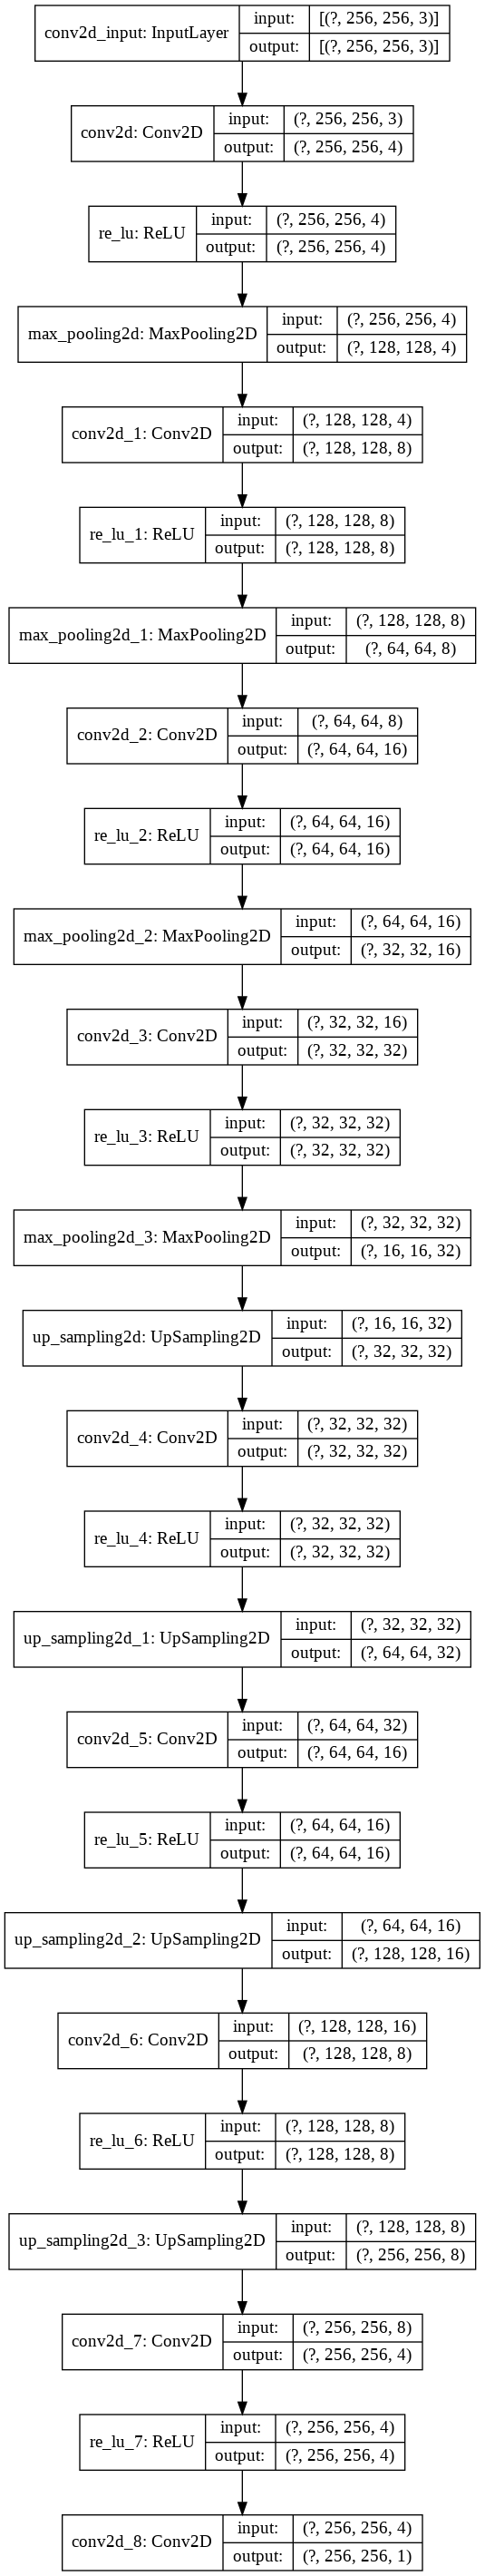

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Training

##**Intersection of Union (IoU) Metric for Validation**
We use the following metric to monitor the model performance while is being trained.

In [0]:
def my_IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax
    
    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

##**Optimization Parameters**

In [0]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------
metrics = [my_IoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#**Training with callbacks**

In [0]:
import os
from datetime import datetime

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True, save_best_only=True, mode='min')  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callbacks)


model_history = model.fit(x=train_dataset,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

Train for 192 steps, validate for 48 steps
Epoch 1/20
192/192 [==============================] - 111s 577ms/step - loss: 0.5154 - my_IoU: 0.0917 - val_loss: 0.5664 - val_my_IoU: 0.3634
Epoch 2/20
192/192 [==============================] - 107s 558ms/step - loss: 0.4645 - my_IoU: 0.2443 - val_loss: 0.5492 - val_my_IoU: 0.1428
Epoch 3/20
192/192 [==============================] - 108s 560ms/step - loss: 0.4584 - my_IoU: 0.2729 - val_loss: 0.5053 - val_my_IoU: 0.3731
Epoch 4/20
192/192 [==============================] - 106s 552ms/step - loss: 0.5437 - my_IoU: 0.0040 - val_loss: 0.6034 - val_my_IoU: 0.0000e+00
Epoch 5/20
192/192 [==============================] - 106s 550ms/step - loss: 0.4556 - my_IoU: 0.2295 - val_loss: 0.4897 - val_my_IoU: 0.2536
Epoch 6/20
192/192 [==============================] - 104s 543ms/step - loss: 0.4385 - my_IoU: 0.3253 - val_loss: 0.4877 - val_my_IoU: 0.3902
Epoch 7/20
192/192 [==============================] - 103s 534ms/step - loss: 0.4320 - my_IoU: 0.3432

#**Visualizing Training**

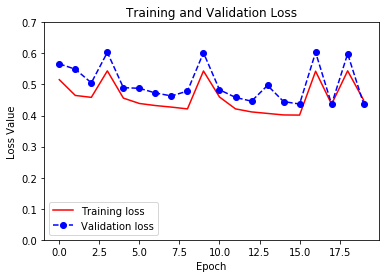

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(20)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.7])
plt.legend()
plt.show()

In [0]:
model.save('transfer_segmentation_scratch.h5') 

In [0]:
cargado = tf.keras.models.load_model('transfer_segmentation_scratch.h5',custom_objects={'my_IoU': my_IoU})
cargado.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 4)       112       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 4)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       296       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

In [0]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

 #Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True, save_best_only=True, mode='min')  # False to save the model directly
callbacks.append(ckpt_callback)


# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callbacks)


cargado_history= loaded_model.fit(x=train_dataset,
                                        epochs=80,  #### set repeat in training dataset
                                        steps_per_epoch=len(train_img_gen),
                                        validation_data=valid_dataset, 
                                        validation_steps=len(valid_img_gen), 
                                        callbacks=callbacks)

Train for 192 steps, validate for 48 steps
Epoch 1/80
192/192 [==============================] - 110s 574ms/step - loss: 0.3880 - my_IoU: 0.4323 - val_loss: 0.4390 - val_my_IoU: 0.4709
Epoch 2/80
192/192 [==============================] - 109s 570ms/step - loss: 0.3916 - my_IoU: 0.4286 - val_loss: 0.4251 - val_my_IoU: 0.4659
Epoch 3/80
192/192 [==============================] - 110s 571ms/step - loss: 0.3901 - my_IoU: 0.4415 - val_loss: 0.4219 - val_my_IoU: 0.4784
Epoch 4/80
192/192 [==============================] - 109s 570ms/step - loss: 0.3857 - my_IoU: 0.4425 - val_loss: 0.4232 - val_my_IoU: 0.4885
Epoch 5/80
192/192 [==============================] - 109s 570ms/step - loss: 0.3789 - my_IoU: 0.4552 - val_loss: 0.4394 - val_my_IoU: 0.4915
Epoch 6/80
192/192 [==============================] - 110s 572ms/step - loss: 0.3804 - my_IoU: 0.4556 - val_loss: 0.4238 - val_my_IoU: 0.5046
Epoch 7/80
192/192 [==============================] - 111s 576ms/step - loss: 0.3787 - my_IoU: 0.4628 - v

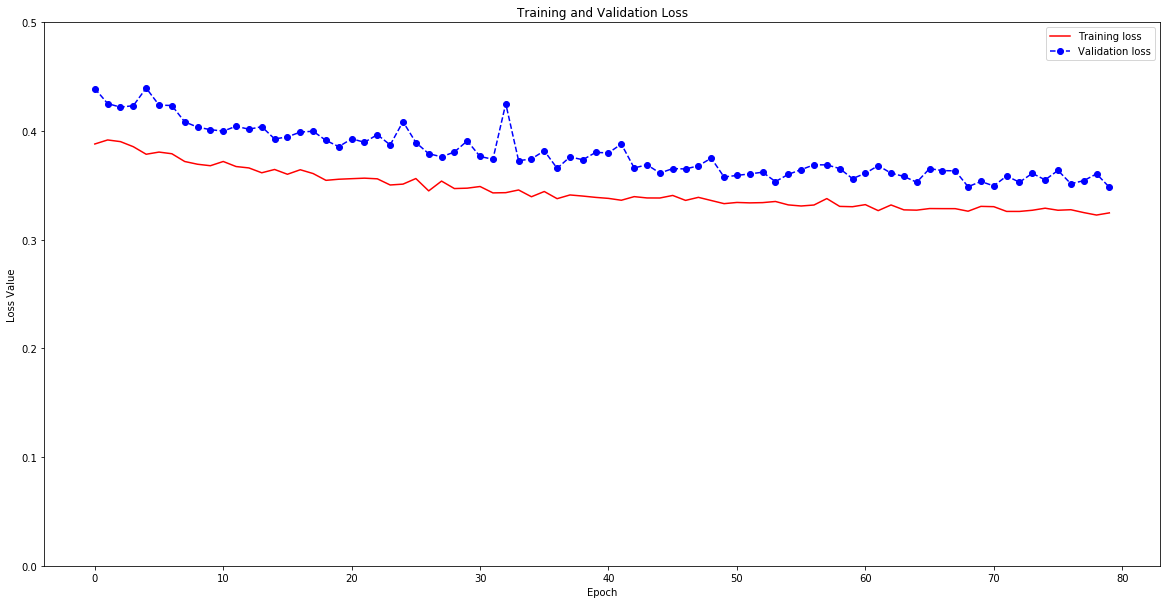

In [39]:
loss = cargado_history.history['loss']
val_loss = cargado_history.history['val_loss']

epochs = range(80)

plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

In [0]:
model.save('transfer_segmentation_scratchBest.h5') 

#**Output of the Solution**

##**CSV Creation**

In [0]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

      f.write('ImageId,EncodedPixels,Width,Height\n')

      for key, value in results.items():
          f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')

##**Encode Prediction Masks**

In [0]:
def rle_encode(img): #Input img is the predicted mask with 0 and 1 values.
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)

In [0]:
from PIL import Image
import time

test_dir = os.path.join(dataset_dir, 'test','images','img') #Path of our test images. 

image_filenames = next(os.walk(test_dir))[2] #Array of all test image files.

results = {}
for img_filename in image_filenames:
    
    mask_filename = img_filename[:-4]
    
    img = Image.open(os.path.join(test_dir, img_filename))
    img = img.resize((256, 256))
    
    img_arr = np.expand_dims(np.array(img), 0)

    img_arr = preprocess_input(img_arr)
    
    predicted_class = model.predict(x=img_arr / 255.)

    predicted_class = tf.cast(predicted_class> 0.5, tf.float32)
    predicted_class = predicted_class[0]

    target = np.array(predicted_class)
    results[mask_filename] = rle_encode(target)

create_csv(results)